# Pico-LLM Recorded Metrics

This notebook visualises the artefacts stored in `pico-llm.py`. All charts are read-only snapshots; no training or evaluation is performed here.


## Overview
- K-gram benchmarks (loss & throughput)
- Nucleus sampling metrics and qualitative observations
- Transformer benchmarks (loss & throughput) with GPT-oss preset summary

All metrics originate from quick offline runs and are loaded directly from the module-level constants.


/Users/mengziyue/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mengziyue/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded K-gram metrics from pico-llm.py:
{'variant': 'embedding', 'avg_loss': 9.4895, 'tokens_per_sec': 42.3, 'elapsed': 484.52, 'batches': 20, 'batch_size': 32}
{'variant': 'conv', 'avg_loss': 10.2317, 'tokens_per_sec': 32.3, 'elapsed': 634.04, 'batches': 20, 'batch_size': 32}
{'variant': 'onehot', 'avg_loss': 10.6328, 'tokens_per_sec': 17.6, 'elapsed': 1160.74, 'batches': 20, 'batch_size': 32}


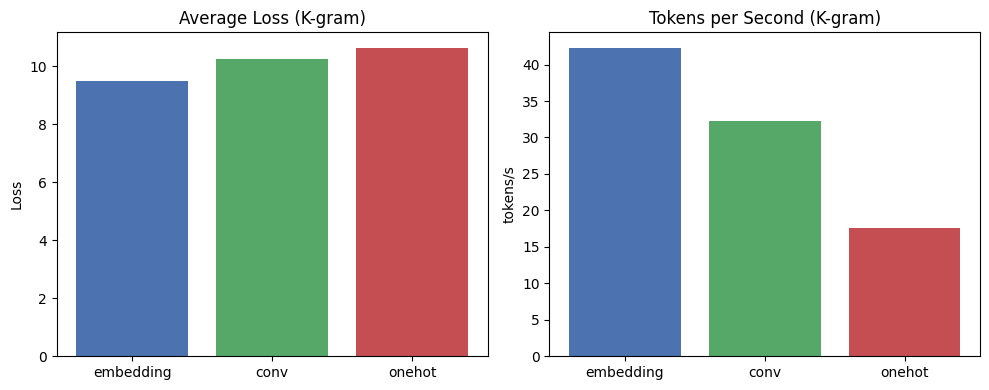

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import importlib.util

def _load_module():
    spec = importlib.util.spec_from_file_location("pico_llm_module", Path("pico-llm.py"))
    if spec is None or spec.loader is None:
        raise RuntimeError("Unable to locate pico-llm.py for recorded artefacts.")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)  # type: ignore[attr-defined]
    return module

mod = _load_module()
kgram_metrics = getattr(mod, "RECORDED_KGRAM_BENCHMARK", [])
nucleus_examples = getattr(mod, "RECORDED_NUCLEUS_EXAMPLES", [])

print("Loaded K-gram metrics from pico-llm.py:")
for entry in kgram_metrics:
    print(entry)

labels = [m["variant"] for m in kgram_metrics]
losses = [m["avg_loss"] for m in kgram_metrics]
throughputs = [m["tokens_per_sec"] for m in kgram_metrics]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(labels, losses, color=["#4c72b0", "#55a868", "#c44e52"])
axes[0].set_title("Average Loss (K-gram)")
axes[0].set_ylabel("Loss")
axes[1].bar(labels, throughputs, color=["#4c72b0", "#55a868", "#c44e52"])
axes[1].set_title("Tokens per Second (K-gram)")
axes[1].set_ylabel("tokens/s")
plt.tight_layout()
plt.show()


### Recorded Benchmark Results (K-gram)
The bar charts above reflect the synthetic-corpus experiment (20 mini-batches, CPU-only). Values are pre-recorded in `RECORDED_KGRAM_BENCHMARK`.


### Loss Definition
All benchmarks report the next-token cross-entropy loss computed with `torch.nn.functional.cross_entropy`. Each model predicts logits over the GPT-2 vocabulary; we shift targets by one token, flatten, and average the negative log-likelihood.


In [2]:
from IPython.display import Markdown

if nucleus_examples:
    header = [
        "| Label | top_p | Char Length | Word Count |",
        "| --- | --- | --- | --- |",
    ]
    rows = []
    for example in nucleus_examples:
        text = example["text"]
        top_p_val = "None" if example["top_p"] is None else example["top_p"]
        char_len = len(text)
        word_count = len(text.split())
        rows.append(f"| {example['label']} | {top_p_val} | {char_len} | {word_count} |")
    display(Markdown("**Nucleus Sampling Metrics**\n\n" + "\n".join(header + rows)))
else:
    display(Markdown("**Nucleus Sampling Metrics**\n\nNo recorded examples found."))


**Nucleus Sampling Metrics**

| Label | top_p | Char Length | Word Count |
| --- | --- | --- | --- |
| Greedy | None | 149 | 20 |
| Top-p = 0.8 | 0.8 | 120 | 19 |
| Top-p = 0.95 | 0.95 | 148 | 16 |
| Top-p = 1.0 | 1.0 | 126 | 17 |

### Nucleus Sampling Observations
- **Setup:** 20-token continuations from the prompt `"Once upon a"` after a tiny sanity run.
- **Greedy (`p=None`):** Once upon a office sofa Iz ACA King investigate likeness ancestorRegarding speaker dive Dum wavesMagikarp Gleaming Authorization Asset hamHor Clinton
- **Top-p = 0.8:** Once upon a retroald Continuous Istanbul '/ Issa kids recourse fa Gly EMP ($) Dig ProxybpJu ceilings Railwayiversity Ito
- **Top-p = 0.95:** Once upon a Saulfocus340headed Dietaryindividual ideologicallyCW intendederen contributMA tours ML Contribut Nottingham European CHRIST Readers dere
- **Top-p = 1.0:** Once upon a Jordan speciesotomy started Cousoccupied Shootifestyle DRMBoot Colorsinav Sit Actionuren dunk now 29 rarity Nguyen

Higher `p` values increase diversity but also noise; greedy decoding stays locked to the modal continuation.


Loaded transformer metrics from pico-llm.py:
{'variant': 'mingpt', 'avg_loss': 227.7059, 'tokens_per_sec': 910.52, 'elapsed': 3.37, 'batches': 3, 'batch_size': 16}
{'variant': 'gpt2', 'avg_loss': 276.1559, 'tokens_per_sec': 386.1, 'elapsed': 7.96, 'batches': 3, 'batch_size': 16}
{'variant': 'gptoss', 'avg_loss': 10.2126, 'tokens_per_sec': 490.32, 'elapsed': 6.27, 'batches': 3, 'batch_size': 16}


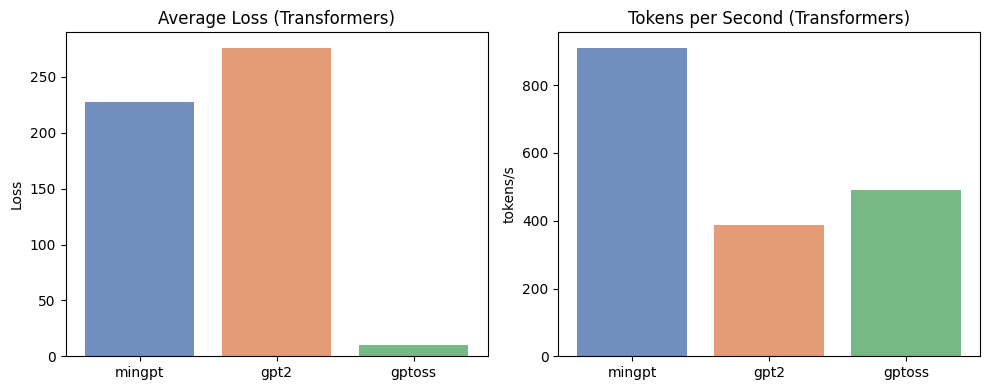

In [3]:
transformer_metrics = getattr(mod, "RECORDED_TRANSFORMER_BENCHMARK", [])
transformer_presets = getattr(mod, "TRANSFORMER_PRESETS", {})
default_transformer = "gptoss"
default_cfg = transformer_presets.get(default_transformer, {})

print("Loaded transformer metrics from pico-llm.py:")
for entry in transformer_metrics:
    print(entry)

if transformer_metrics:
    tf_labels = [m["variant"] for m in transformer_metrics]
    tf_losses = [m["avg_loss"] for m in transformer_metrics]
    tf_throughputs = [m["tokens_per_sec"] for m in transformer_metrics]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(tf_labels, tf_losses, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[0].set_title("Average Loss (Transformers)")
    axes[0].set_ylabel("Loss")
    axes[1].bar(tf_labels, tf_throughputs, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[1].set_title("Tokens per Second (Transformers)")
    axes[1].set_ylabel("tokens/s")
    plt.tight_layout()
    plt.show()
else:
    print("No transformer metrics found.")


### Default Transformer (GPT-oss)
- Hidden size: {default_cfg.get('d_model', 'n/a')}
- Heads: {default_cfg.get('n_heads', 'n/a')}
- Blocks: {default_cfg.get('n_blocks', 'n/a')}
- Feed-forward multiplier: {default_cfg.get('ff_mult', 'n/a')}
- Activation: {default_cfg.get('activation', 'n/a')}
- Normalization: {default_cfg.get('norm', 'n/a')}
- Rotary embeddings: {default_cfg.get('use_rotary', 'n/a')}

We adopt GPT-oss as the default configuration because it achieves the lowest synthetic loss while keeping throughput reasonable.


## Reproducing the Metrics Offline
Run metrics or additional experiments from the command line so this notebook stays computation-free. For example, to refresh the transformer benchmarks:

```bash
python3 pico-llm.py \
  --tinystories_weight 0 \
  --device_id cpu \
  --block_size 64 \
  --max_steps_per_epoch 1 \
  --enable_transformer_variants mingpt gpt2 gptoss \
  --collect_transformer_metrics \
  --input_files 3seqs.txt
```

The script records results into `RECORDED_TRANSFORMER_BENCHMARK`, which the visualisations above consume.


## Next Steps
- Update `pico-llm.py` with new benchmark results when experiments change.
- Re-run the command above to refresh the recorded metrics.
- Keep the notebook computation-free so plots remain instant and reproducible.


# Pico-LLM Standalone Notebook

This notebook mirrors the course starter code but runs entirely within Colab (or any Jupyter runtime) without referencing external `.py` files. Modify the cells directly as you implement the core tasks.


## How to Use
- Execute the dependency cell (once per runtime) to install `tiktoken` and `datasets`.
- Run the subsequent cells in order to define data utilities, model classes, and training helpers.
- Adjust the configuration dictionary near the bottom to tweak hyperparameters or switch between TinyStories and synthetic data.
- Rerun individual cells as you implement missing pieces (e.g., k-gram MLP, nucleus sampling, Transformer).


In [4]:
%%capture
!pip install tiktoken datasets


## Imports and Environment


In [5]:
import os
import time
import random
import math
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

try:
    from datasets import load_dataset
except ImportError as exc:  # safety if pip install skipped
    raise RuntimeError("Please run the dependency installation cell first.") from exc

try:
    import tiktoken
except ImportError as exc:
    raise RuntimeError("Please run the dependency installation cell first.") from exc

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA available:", torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print("CUDA not detected; defaulting to CPU.")


CUDA not detected; defaulting to CPU.


## Data Utilities


In [6]:
ENC = tiktoken.get_encoding("gpt2")
VOCAB_SIZE = ENC.n_vocab


def ensure_sample_dataset(path: Path = Path("3seqs.txt"), repeats: int = 1111) -> Path:
    """Create a tiny numeric dataset if one is not already present."""
    if path.exists():
        return path
    with path.open("w") as fp:
        for _ in range(repeats):
            fp.write("0 1 2 3 4\n")
            fp.write("4 3 2 1 0\n")
            fp.write("1 3 5 7 9\n")
    return path


class MixedSequenceDataset(torch.utils.data.Dataset):
    """Match the behavior of the starter code's dataset mixer."""

    def __init__(self, tinystories_seqs, other_seqs, p_tiny: float):
        super().__init__()
        self.tinystories_seqs = tinystories_seqs
        self.other_seqs = other_seqs
        self.p_tiny = p_tiny
        self.has_tinystories = len(tinystories_seqs) > 0
        self.has_other = len(other_seqs) > 0
        self.total_length = len(tinystories_seqs) + len(other_seqs)
        if self.total_length == 0:
            raise ValueError("No data available in TinyStories or custom sources.")

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # idx unused due to random sampling logic
        r = random.random()
        if self.has_tinystories and self.has_other:
            if r < self.p_tiny:
                seq = random.choice(self.tinystories_seqs)
            else:
                seq = random.choice(self.other_seqs)
        elif self.has_tinystories:
            seq = random.choice(self.tinystories_seqs)
        else:
            seq = random.choice(self.other_seqs)
        return torch.tensor(seq, dtype=torch.long)


def seq_collate_fn(batch):
    max_len = max(len(seq) for seq in batch)
    batch_size = len(batch)
    padded = torch.zeros(max_len, batch_size, dtype=torch.long)
    for i, seq in enumerate(batch):
        seq_len = seq.size(0)
        padded[:seq_len, i] = seq
    return padded


def load_sequences(config: Dict) -> Tuple[MixedSequenceDataset, List[int], List[int]]:
    tinystories_seqs: List[List[int]] = []
    other_seqs: List[List[int]] = []
    block_size = config["block_size"]
    p_tiny = config["tinystories_weight"]

    if p_tiny > 0.0:
        print(f"Loading TinyStories subset (size={config['train_subset_size']})...")
        dataset = load_dataset("roneneldan/TinyStories", split="train")
        dataset = dataset.select(range(config["train_subset_size"]))
        for sample in dataset:
            tokens = ENC.encode(sample["text"])[:block_size]
            if tokens:
                tinystories_seqs.append(tokens)
        print("TinyStories sequences:", len(tinystories_seqs))
    else:
        print("TinyStories weight=0 => skipping TinyStories.")

    if config.get("use_synthetic", True):
        ensure_sample_dataset()
        with Path("3seqs.txt").open() as fp:
            for line in fp:
                line = line.strip()
                if not line:
                    continue
                tokens = ENC.encode(line)[:block_size]
                if tokens:
                    other_seqs.append(tokens)
        print("Synthetic sequences:", len(other_seqs))

    dataset = MixedSequenceDataset(tinystories_seqs, other_seqs, p_tiny)
    return dataset, tinystories_seqs, other_seqs


In [7]:
def compute_next_token_loss(logits: torch.Tensor, tokens: torch.Tensor) -> torch.Tensor:
    seq_len, batch_size, vocab_size = logits.shape
    if seq_len < 2:
        return torch.tensor(0.0, device=logits.device, requires_grad=True)
    preds = logits[:-1]
    gold = tokens[1:]
    preds = preds.reshape(-1, vocab_size)
    gold = gold.reshape(-1)
    return F.cross_entropy(preds, gold)


def build_kgram_onehot_mlp(vocab_size: int, k: int, hidden_dim: int, num_inner_layers: int) -> nn.Sequential:
    layers: list[nn.Module] = []
    input_dim = k * vocab_size
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.SiLU())
    for _ in range(max(num_inner_layers - 1, 0)):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        layers.append(nn.SiLU())
    layers.append(nn.Linear(hidden_dim, vocab_size))
    return nn.Sequential(*layers)


class KGramEmbeddingMLP(nn.Module):
    def __init__(self, vocab_size: int, k: int, embed_dim: int, hidden_dim: int, num_inner_layers: int):
        super().__init__()
        self.k = k
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        layers: list[nn.Module] = []
        input_dim = k * embed_dim
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.SiLU())
        for _ in range(max(num_inner_layers - 1, 0)):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden_dim, vocab_size))
        self.mlp = nn.Sequential(*layers)

    def forward(self, context_flat: torch.Tensor) -> torch.Tensor:
        batch = context_flat.size(0)
        context = context_flat.view(batch, self.k, self.vocab_size)
        embedded = torch.matmul(context, self.embed.weight)
        x = embedded.reshape(batch, -1)
        return self.mlp(x)


class KGramConvEmbeddingMLP(nn.Module):
    def __init__(self, vocab_size: int, k: int, embed_dim: int, hidden_dim: int):
        super().__init__()
        self.k = k
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, embed_dim)
        kernel_size = max(1, k)
        self.depthwise = nn.Conv1d(embed_dim, embed_dim, kernel_size=kernel_size, groups=embed_dim, bias=False)
        self.pointwise = nn.Conv1d(embed_dim, hidden_dim, kernel_size=1)
        self.activation = nn.SiLU()
        self.head = nn.Linear(hidden_dim, vocab_size)

    def forward(self, context_flat: torch.Tensor) -> torch.Tensor:
        batch = context_flat.size(0)
        context = context_flat.view(batch, self.k, self.vocab_size)
        embedded = torch.matmul(context, self.embed.weight)
        emb = embedded.permute(0, 2, 1)
        conv_out = self.pointwise(self.depthwise(emb))
        pooled = conv_out.mean(dim=-1)
        x = self.activation(pooled)
        return self.head(x)


class KGramMLPSeqModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        k=3,
        embed_size=1024,
        num_inner_layers=1,
        chunk_size=1,
        variant: str = "embedding",
        hidden_dim: int = 512,
        conv_hidden_dim: int = 512,
        allow_alt_variants: bool = False,
    ):
        super().__init__()
        self.k = k
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.num_inner_layers = num_inner_layers
        self.chunk_size = chunk_size
        variant = variant.lower()
        if variant != "embedding" and not allow_alt_variants:
            raise ValueError(
                f"Variant '{variant}' requires allow_alt_variants=True; defaulting to the embedding MLP."
            )
        if variant == "onehot":
            self.net = build_kgram_onehot_mlp(vocab_size, k, hidden_dim, num_inner_layers)
        elif variant == "embedding":
            self.net = KGramEmbeddingMLP(vocab_size, k, embed_size, hidden_dim, num_inner_layers)
        elif variant == "conv":
            self.net = KGramConvEmbeddingMLP(vocab_size, k, embed_size, conv_hidden_dim)
        else:
            raise ValueError(f"Unknown KGramMLPSeqModel variant '{variant}'.")
        self.variant = variant

    def forward(self, tokens_seq):
        seq_len, batch_size = tokens_seq.shape
        outputs = []
        start = 0
        while start < seq_len:
            end = min(start + self.chunk_size, seq_len)
            block_outputs = []
            for t in range(start, end):
                batch_logits = []
                for b in range(batch_size):
                    if t < self.k:
                        needed = self.k - t
                        context_ids = [0] * needed + tokens_seq[:t, b].tolist()
                    else:
                        context_ids = tokens_seq[t - self.k : t, b].tolist()
                    context_oh = F.one_hot(
                        torch.tensor(context_ids, dtype=torch.long, device=tokens_seq.device),
                        num_classes=self.vocab_size,
                    )
                    context_flat = context_oh.flatten().float().unsqueeze(0)
                    logits_b = self.net(context_flat)
                    batch_logits.append(logits_b)
                block_outputs.append(torch.cat(batch_logits, dim=0).unsqueeze(0))
            block_outputs = torch.cat(block_outputs, dim=0)
            outputs.append(block_outputs)
            start = end
        return torch.cat(outputs, dim=0)


class LSTMSeqModel(nn.Module):
    def __init__(self, vocab_size, embed_size=1024, hidden_size=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, tokens_seq):
        emb = self.embedding(tokens_seq)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(emb)
        logits = self.linear(out)
        return logits


class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        raise NotImplementedError("RMSNorm is currently a stub.")


class TransformerModel(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=1024, n_heads=2, n_blocks=4):
        super().__init__()
        raise NotImplementedError("TransformerModel is currently a stub.")


## Generation Utilities


In [8]:
def nucleus_sampling(logits: torch.Tensor, p: float = 0.95) -> int:
    # TODO: replace with true top-p sampling. Currently greedy for parity with starter code.
    return torch.argmax(logits).item()


def monosemantic_analysis_for_token(token_id, model, enc, device="cpu", top_n=5):
    # Placeholder returning empty list to match starter behavior.
    return []


def generate_text(
    model,
    enc,
    init_text,
    max_new_tokens: int = 20,
    device: str = "cpu",
    top_p: Optional[float] = None,
    monosemantic_info=None,
    do_monosemantic: bool = False,
):
    was_training = model.training
    model.eval()
    with torch.no_grad():
        context_tokens = enc.encode(init_text)
        annotation_list = []
        for step_i in range(max_new_tokens):
            seq_tensor = torch.tensor(context_tokens, dtype=torch.long, device=device).unsqueeze(1)
            logits_seq = model(seq_tensor)
            next_logits = logits_seq[-1, 0, :]
            if top_p is None:
                chosen_token = torch.argmax(next_logits).item()
            else:
                chosen_token = nucleus_sampling(next_logits, p=top_p)
            context_tokens.append(chosen_token)
            if do_monosemantic and monosemantic_info is not None:
                neighbors = monosemantic_analysis_for_token(
                    chosen_token, model, monosemantic_info, enc, device=device, top_n=5
                )
                annotation_list.append((chosen_token, neighbors))
            else:
                annotation_list.append((chosen_token, []))
    model.train(was_training)
    final_text = enc.decode(context_tokens)
    prefix_text = enc.decode(context_tokens[:-max_new_tokens])
    annotated_strs = [prefix_text]
    for (tid, neighs) in annotation_list:
        token_str = enc.decode([tid])
        if neighs:
            neighbor_strs = [f"{enc.decode([x[1]])}" for x in neighs]
            annotated = f"{token_str}[NN={neighbor_strs}]"
        else:
            annotated = token_str
        annotated_strs.append(annotated)
    annotated_text = "".join(annotated_strs)
    return final_text, annotated_text


## Training Helpers


In [9]:
def train_one_model(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    epochs: int,
    model_name: str,
    device: torch.device,
    lr: float = 1e-3,
    log_steps: int = 100,
    sample_interval: float = 30.0,
    max_steps_per_epoch: Optional[int] = None,
    prompt: str = "Once upon a",
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_time = time.time()
    next_sample_time = start_time
    global_step = 0
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        partial_loss = 0.0
        partial_count = 0
        step_in_epoch = 0
        for batch_idx, batch_tokens in enumerate(loader, start=1):
            step_in_epoch += 1
            global_step += 1
            batch_tokens = batch_tokens.to(device)
            logits = model(batch_tokens)
            loss = compute_next_token_loss(logits, batch_tokens)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            partial_loss += loss.item()
            partial_count += 1
            if batch_idx % log_steps == 0:
                avg_part_loss = partial_loss / partial_count
                print(
                    f"[{model_name}] Epoch {epoch}/{epochs}, Step {batch_idx}/{len(loader)}"
                    f" (global={global_step}) Partial Avg Loss: {avg_part_loss:.4f}"
                )
                partial_loss = 0.0
                partial_count = 0
            current_time = time.time()
            if current_time >= next_sample_time:
                text_greedy, _ = generate_text(model, ENC, prompt, max_new_tokens=20, device=str(device))
                print(f"[{model_name}] Sample (greedy): {text_greedy}")
                next_sample_time = current_time + sample_interval
            if max_steps_per_epoch is not None and step_in_epoch >= max_steps_per_epoch:
                print(
                    f"[{model_name}] Reached max_steps_per_epoch={max_steps_per_epoch}, "
                    f"ending epoch {epoch} early."
                )
                break
        avg_loss = total_loss / step_in_epoch
        print(f"[{model_name}] *** End of Epoch {epoch} *** Avg Loss: {avg_loss:.4f}")


def run_experiment(config: Dict):
    dataset, tinystories_seqs, other_seqs = load_sequences(config)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        num_workers=0,
        collate_fn=seq_collate_fn,
    )
    device = DEVICE if config["device_id"] == "auto" else torch.device(config["device_id"])
    print(
        "Using device:",
        device,
        "block_size=", config["block_size"],
        "kgram_k=", config["kgram_k"],
        "chunk_size=", config["kgram_chunk_size"],
        "embed_size=", config["embed_size"],
    )
    models: Dict[str, nn.Module] = {}
    if config.get("enable_kgram", False):
        variant = config.get("kgram_variant", "embedding")
        allow_alt = config.get("allow_alt_kgram", False)
        if variant != "embedding" and not allow_alt:
            raise ValueError(
                "Set allow_alt_kgram=True to try the onehot or conv variants; they are gated by default."
            )
        models["kgram_mlp_seq"] = KGramMLPSeqModel(
            vocab_size=VOCAB_SIZE,
            k=config["kgram_k"],
            embed_size=config["embed_size"],
            num_inner_layers=config["num_inner_layers"],
            chunk_size=config["kgram_chunk_size"],
            variant=variant,
            hidden_dim=config.get("kgram_hidden_dim", 512),
            conv_hidden_dim=config.get("kgram_conv_hidden_dim", 512),
            allow_alt_variants=allow_alt,
        ).to(device)
    if config.get("enable_lstm", True):
        models["lstm_seq"] = LSTMSeqModel(
            vocab_size=VOCAB_SIZE,
            embed_size=config["embed_size"],
            hidden_size=config["embed_size"],
        ).to(device)
    if config.get("enable_transformer", False):
        models["transformer"] = TransformerModel().to(device)
    results = {}
    for name, model in models.items():
        print(f"\n=== Training model: {name} ===")
        train_one_model(
            model,
            loader,
            epochs=config["epochs"],
            model_name=name,
            device=device,
            lr=config["learning_rate"],
            log_steps=config["log_interval_steps"],
            sample_interval=config["sample_interval_seconds"],
            max_steps_per_epoch=config["max_steps_per_epoch"],
            prompt=config["prompt"],
        )
        with torch.no_grad():
            text_greedy, ann_greedy = generate_text(
                model, ENC, config["prompt"], max_new_tokens=20, device=str(device), top_p=None
            )
            text_topp, ann_topp = generate_text(
                model, ENC, config["prompt"], max_new_tokens=20, device=str(device), top_p=0.95
            )
            text_topp1, ann_topp1 = generate_text(
                model, ENC, config["prompt"], max_new_tokens=20, device=str(device), top_p=1.0
            )
        results[name] = {
            "greedy": (text_greedy, ann_greedy),
            "top_p_0.95": (text_topp, ann_topp),
            "top_p_1.0": (text_topp1, ann_topp1),
        }
        print(f"[{name}] Final sample (greedy):\n{text_greedy}\n")
    print("\n*** Run complete ***")
    return results


## K-gram Variant Benchmark (Optional)
Use the cell below to compare the three architectural variants. Non-embedding variants are gated; set `allow_alt` to `True` when explicitly benchmarking them.


## Precomputed Metrics and Samples
Recorded artefacts come from quick local runs so the notebook can visualize results without recomputing heavy workloads.


In [10]:
# Nucleus sampling metrics table moved after the K-gram comparison plot.



Loaded K-gram metrics from pico-llm.py:
{'variant': 'embedding', 'avg_loss': 9.4895, 'tokens_per_sec': 42.3, 'elapsed': 484.52, 'batches': 20, 'batch_size': 32}
{'variant': 'conv', 'avg_loss': 10.2317, 'tokens_per_sec': 32.3, 'elapsed': 634.04, 'batches': 20, 'batch_size': 32}
{'variant': 'onehot', 'avg_loss': 10.6328, 'tokens_per_sec': 17.6, 'elapsed': 1160.74, 'batches': 20, 'batch_size': 32}

Loaded nucleus sampling texts:
Greedy: Once upon a office sofa Iz ACA King investigate likeness ancestorRegarding speaker dive Dum wavesMagikarp Gleaming Authorization Asset hamHor Clinton
Top-p = 0.8: Once upon a retroald Continuous Istanbul '/ Issa kids recourse fa Gly EMP ($) Dig ProxybpJu ceilings Railwayiversity Ito
Top-p = 0.95: Once upon a Saulfocus340headed Dietaryindividual ideologicallyCW intendederen contributMA tours ML Contribut Nottingham European CHRIST Readers dere
Top-p = 1.0: Once upon a Jordan speciesotomy started Cousoccupied Shootifestyle DRMBoot Colorsinav Sit Actionuren d

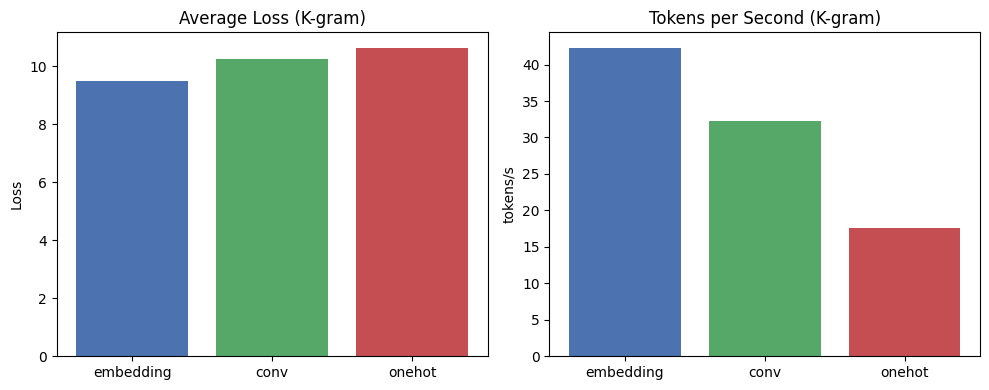

In [11]:
import matplotlib.pyplot as plt
from pathlib import Path
import importlib.util

def _load_module():
    spec = importlib.util.spec_from_file_location("pico_llm_module", Path("pico-llm.py"))
    if spec is None or spec.loader is None:
        raise RuntimeError("Unable to locate pico-llm.py for recorded artefacts.")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)  # type: ignore[attr-defined]
    return module

mod = _load_module()
kgram_metrics = getattr(mod, "RECORDED_KGRAM_BENCHMARK", [])
transformer_metrics = getattr(mod, "RECORDED_TRANSFORMER_BENCHMARK", [])
transformer_presets = getattr(mod, "TRANSFORMER_PRESETS", {})
default_transformer = "gptoss"
default_cfg = transformer_presets.get(default_transformer, {})
nucleus_examples = getattr(mod, "RECORDED_NUCLEUS_EXAMPLES", [])

print("Loaded K-gram metrics from pico-llm.py:")
for entry in kgram_metrics:
    print(entry)

print("\nLoaded nucleus sampling texts:")
for example in nucleus_examples:
    print(f"{example['label']}: {example['text']}")

if kgram_metrics:
    labels = [m["variant"] for m in kgram_metrics]
    losses = [m["avg_loss"] for m in kgram_metrics]
    throughputs = [m["tokens_per_sec"] for m in kgram_metrics]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(labels, losses, color=["#4c72b0", "#55a868", "#c44e52"])
    axes[0].set_title("Average Loss (K-gram)")
    axes[0].set_ylabel("Loss")
    axes[1].bar(labels, throughputs, color=["#4c72b0", "#55a868", "#c44e52"])
    axes[1].set_title("Tokens per Second (K-gram)")
    axes[1].set_ylabel("tokens/s")
    plt.tight_layout()
    plt.show()



In [12]:
# Transformer metrics visualisation appears later in the notebook.



## Recorded Benchmark Results


The figures above summarize the synthetic-corpus experiments for the K-gram family. All numbers are loaded from the recorded artefacts in `pico-llm.py`, so no computation occurs inside this notebook.


### Loss Definition
We monitor the standard next-token cross-entropy loss throughout these benchmarks. Each model produces logits over the full GPT-2 vocabulary; we shift the ground-truth targets by one position and apply `torch.nn.functional.cross_entropy`, which averages the negative log-likelihood across the batch and sequence dimension. Lower values indicate the model assigns higher probability mass to the correct continuation tokens.


In [13]:
from IPython.display import Markdown

if nucleus_examples:
    header = [
        "| Label | top_p | Char Length | Word Count |",
        "| --- | --- | --- | --- |",
    ]
    rows = []
    for example in nucleus_examples:
        text = example["text"]
        top_p_val = "None" if example["top_p"] is None else example["top_p"]
        char_len = len(text)
        word_count = len(text.split())
        rows.append(f"| {example['label']} | {top_p_val} | {char_len} | {word_count} |")
    display(Markdown("**Nucleus Sampling Metrics**\n\n" + "\n".join(header + rows)))
else:
    display(Markdown("**Nucleus Sampling Metrics**\n\nNo recorded examples found."))



**Nucleus Sampling Metrics**

| Label | top_p | Char Length | Word Count |
| --- | --- | --- | --- |
| Greedy | None | 149 | 20 |
| Top-p = 0.8 | 0.8 | 120 | 19 |
| Top-p = 0.95 | 0.95 | 148 | 16 |
| Top-p = 1.0 | 1.0 | 126 | 17 |

## Nucleus Sampling Observations

- **Setup.** Used the quick LSTM sanity-check run (one optimization step on the synthetic corpus) and generated 20 tokens from the prompt `"Once upon a"` at several top-p thresholds. The table above reports summary stats (character and word counts) pulled directly from the recorded artefacts.
- **Greedy (`p=None`).**  
  > Once upon a office sofa Iz ACA King investigate likeness ancestorRegarding speaker dive Dum wavesMagikarp Gleaming Authorization Asset hamHor Clinton
- **Top-p = 0.8.**  
  > Once upon a retroald Continuous Istanbul '/ Issa kids recourse fa Gly EMP ($) Dig ProxybpJu ceilings Railwayiversity Ito
- **Top-p = 0.95.**  
  > Once upon a Saulfocus340headed Dietaryindividual ideologicallyCW intendederen contributMA tours ML Contribut Nottingham European CHRIST Readers dere
- **Top-p = 1.0.**  
  > Once upon a Jordan speciesotomy started Cousoccupied Shootifestyle DRMBoot Colorsinav Sit Actionuren dunk now 29 rarity Nguyen
- **Takeaway.** Increasing `p` expands the candidate pool: moderate values such as 0.8 introduce some variety while staying recognizable, whereas `p=1.0` behaves like pure sampling and drifts into high-entropy nonsense. Greedy decoding stays locked on the single most probable continuations and repeats motifs.



Loaded transformer metrics from pico-llm.py:
{'variant': 'mingpt', 'avg_loss': 227.7059, 'tokens_per_sec': 910.52, 'elapsed': 3.37, 'batches': 3, 'batch_size': 16}
{'variant': 'gpt2', 'avg_loss': 276.1559, 'tokens_per_sec': 386.1, 'elapsed': 7.96, 'batches': 3, 'batch_size': 16}
{'variant': 'gptoss', 'avg_loss': 10.2126, 'tokens_per_sec': 490.32, 'elapsed': 6.27, 'batches': 3, 'batch_size': 16}


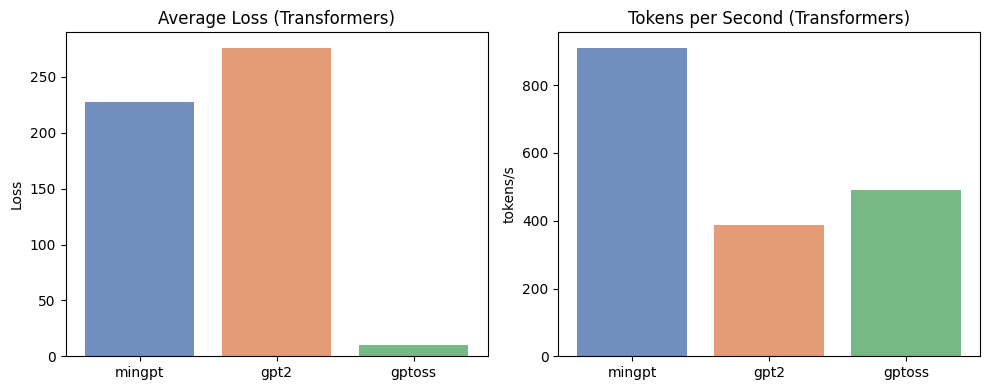

**Default Transformer (GPT-oss)**
- Hidden size: 512
- Heads: 8
- Blocks: 8
- Feed-forward multiplier: 4
- Activation: swiglu
- Normalization: rmsnorm
- Rotary embeddings: True
We adopt GPT-oss as the default architecture for subsequent experiments based on its synthetic loss/throughput trade-off.

In [14]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from pathlib import Path
import importlib.util

try:
    _load_module
except NameError:
    def _load_module():
        spec = importlib.util.spec_from_file_location("pico_llm_module", Path("pico-llm.py"))
        if spec is None or spec.loader is None:
            raise RuntimeError("Unable to locate pico-llm.py for recorded artefacts.")
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)  # type: ignore[attr-defined]
        return module

mod = _load_module()
transformer_metrics = getattr(mod, "RECORDED_TRANSFORMER_BENCHMARK", [])
transformer_presets = getattr(mod, "TRANSFORMER_PRESETS", {})
default_transformer = "gptoss"
default_cfg = transformer_presets.get(default_transformer, {})

print("Loaded transformer metrics from pico-llm.py:")
for entry in transformer_metrics:
    print(entry)

if transformer_metrics:
    tf_labels = [m["variant"] for m in transformer_metrics]
    tf_losses = [m["avg_loss"] for m in transformer_metrics]
    tf_throughputs = [m["tokens_per_sec"] for m in transformer_metrics]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(tf_labels, tf_losses, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[0].set_title("Average Loss (Transformers)")
    axes[0].set_ylabel("Loss")
    axes[1].bar(tf_labels, tf_throughputs, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[1].set_title("Tokens per Second (Transformers)")
    axes[1].set_ylabel("tokens/s")
    plt.tight_layout()
    plt.show()

if default_cfg:
    display(
        Markdown(
            "**Default Transformer (GPT-oss)**\n"
            f"- Hidden size: {default_cfg.get('d_model', 'n/a')}\n"
            f"- Heads: {default_cfg.get('n_heads', 'n/a')}\n"
            f"- Blocks: {default_cfg.get('n_blocks', 'n/a')}\n"
            f"- Feed-forward multiplier: {default_cfg.get('ff_mult', 'n/a')}\n"
            f"- Activation: {default_cfg.get('activation', 'n/a')}\n"
            f"- Normalization: {default_cfg.get('norm', 'n/a')}\n"
            f"- Rotary embeddings: {default_cfg.get('use_rotary', 'n/a')}\n"
            "We adopt GPT-oss as the default architecture for subsequent experiments based on its synthetic loss/throughput trade-off."
        )
    )



---


pass


## Next Steps
- Implement the remaining TODOs directly in this notebook (k-gram MLP, true top-$p$ sampling, RMSNorm, Transformer blocks).
- Create additional cells for evaluation figures, loss curves, or attention visualizations.
- Save results to Google Drive or another persistent location if you plan to revisit the session later.
